In [67]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, recall_score
from scipy.stats import zscore
import matplotlib
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv("Dataset.csv")
df = pd.DataFrame(df)
df = df.drop(columns='Info')
df = df.drop(columns='Frame length')
df = df.drop(columns=['No.'])
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df = df.rename(columns= {'Time since previous frame' : 'Time since previous frame mean', 'Data length' : 'Data length mean'})

df.head()

,Time,Time since previous frame mean,Source,Destination,Time to Live,Data length mean,Protocol
0,1970-01-01 00:00:00.000000,0.000000,151.30.61.46,192.168.1.3,53,825,UDP
1,1970-01-01 00:00:00.000323,0.000323,151.30.61.46,192.168.1.3,53,824,UDP
2,1970-01-01 00:00:00.000703,0.000380,151.30.61.46,192.168.1.3,53,1014,UDP
3,1970-01-01 00:00:00.001089,0.000386,151.30.61.46,192.168.1.3,53,1014,UDP
4,1970-01-01 00:00:00.001091,0.000002,151.30.61.46,192.168.1.3,53,1014,UDP


In order to create a useful dataset to fit the models, we have to create samples by windowing the raw dataset with window of T seconds.
While aggregating every T seconds, we compute some useful features.

In [69]:
dst_address = "151.30.61.46"
time_window = "0.5S"

In [70]:
df['Data length std'] = df['Data length mean']
df['Data length median'] = df['Data length mean']
df['Time since previous frame std'] = df['Time since previous frame mean']
df['Time since previous frame median'] = df['Time since previous frame mean']

df_complete = df.resample(time_window, on='Time').agg(
    {'Time to Live' : np.mean, 'Time since previous frame mean' : np.mean, 'Time since previous frame std' : 'std', 'Time since previous frame median' : np.median,
     'Data length mean' : np.mean, 'Data length std' : 'std', 'Data length median': np.median})

Since we want to compute the rate of inbound and outbound packets, we retrieve two sub-datasets to compute them.
Once computed, the columns are added to the original dataset.

In [71]:
df_inbound = df.loc[df['Source'] == dst_address]
df_outbound = df.loc[df['Destination'] == dst_address]

df_inbound = df_inbound.drop(columns=['Destination'])
df_outbound = df_outbound.drop(columns=['Source'])

In [72]:
df_inbound = df_inbound.resample(time_window, on='Time').agg(
    {'Source' : 'count'})

df_inbound = df_inbound.rename(columns={'Source' : 'Inbound Count'})


df_outbound = df_outbound.resample(time_window, on='Time').agg(
    {'Destination' : 'count'})

df_outbound = df_outbound.rename(columns={'Destination' : 'Outbound Count'})

In [73]:
inbound_count = df_inbound["Inbound Count"]
outbound_count = df_outbound["Outbound Count"]

df_complete = df_complete.join(inbound_count)
df_complete = df_complete.join(outbound_count)

df_complete.reset_index(inplace=True)

df_complete['Time'] = df_complete['Time'].dt.time

In [74]:
df_complete.head()

,Time,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count
0,00:00:00,58.238095,0.001299,0.003175,0.000002,877.436508,323.765957,981.0,198,180
1,00:00:00.500000,58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189
2,00:00:01,58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171
3,00:00:01.500000,58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184
4,00:00:02,58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184


In [75]:
labels = pd.read_csv("Labels.csv")
labels = pd.DataFrame(labels)

labels.head()

,label
0,1
1,1
2,1
3,1
4,1


In [76]:
df_complete = df_complete.join(labels)

In [77]:
df_complete.head()

,Time,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,label
0,00:00:00,58.238095,0.001299,0.003175,0.000002,877.436508,323.765957,981.0,198,180,1
1,00:00:00.500000,58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189,1
2,00:00:01,58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171,1
3,00:00:01.500000,58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184,1
4,00:00:02,58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184,1


In [78]:
df_complete = df_complete.dropna()
df_complete = df_complete.drop(columns='Time')
df_complete['label'] = df_complete['label'].astype(int)

df_complete

,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,label
0,58.238095,0.001299,0.003175,0.000002,877.436508,323.765957,981.0,198,180,1
1,58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189,1
2,58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171,1
3,58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184,1
4,58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184,1
...,...,...,...,...,...,...,...,...,...,...
1915,58.575342,0.001322,0.003420,0.000002,788.991781,324.468970,918.0,180,185,0
1916,58.660819,0.001443,0.003731,0.000002,774.435673,332.119878,892.0,166,176,0
1917,58.860119,0.001420,0.003426,0.000002,773.125000,336.355829,857.5,157,179,0
1918,58.804665,0.001429,0.003631,0.000001,757.463557,333.282449,833.0,162,181,0


In [79]:
# normalizing data

cols = df_complete.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_complete)
df_complete = pd.DataFrame(np_scaled, columns = cols)

In [80]:
df_complete = df_complete.reset_index()

In [81]:
df_complete.head()

,index,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,label
0,0,0.553600,0.308476,0.293138,0.142857,0.807278,0.307176,0.833866,0.500000,0.496599,1.0
1,1,0.642971,0.338454,0.301733,0.142857,0.701094,0.316331,0.774760,0.427778,0.557823,1.0
2,2,0.658604,0.462564,0.335660,0.142857,0.569406,0.471995,0.651757,0.311111,0.435374,1.0
3,3,0.634954,0.404452,0.375884,0.142857,0.621330,0.415670,0.674121,0.411111,0.523810,1.0
4,4,0.610100,0.353873,0.398924,0.142857,0.625668,0.370223,0.816294,0.444444,0.523810,1.0


In [82]:
X = df_complete.loc[:, df_complete.columns != 'label']
Y = df_complete['label']

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [84]:
model = KNeighborsClassifier(n_neighbors=17)
model.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=17)

In [85]:
y_pred_class1 = model.predict(X_test)
expected = Y_test
indexes = expected.index

In [86]:
print("RMS: %r " % np.sqrt(np.mean((y_pred_class1 - expected) ** 2)))

RMS: 0.11023963796102461 


In [87]:
from sklearn import metrics
metrics.accuracy_score(expected, y_pred_class1)

0.9878472222222222

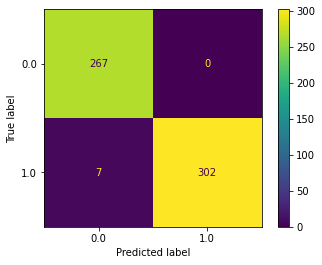

In [88]:
conf_matrix = confusion_matrix(y_true=expected, y_pred=y_pred_class1, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)

disp.plot()

plt.show()

In [89]:
expected = pd.DataFrame(expected)
expected

,label
998,0.0
1621,0.0
611,0.0
514,1.0
413,0.0
...,...
706,0.0
982,0.0
1289,1.0
1366,1.0


In [90]:
y_pred_class1 = pd.DataFrame(y_pred_class1)
y_pred_class1

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
571,0.0
572,0.0
573,1.0
574,1.0


In [91]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
y_pred_class2 = model.fit(X_train, Y_train).predict(X_test)

metrics.accuracy_score(expected, y_pred_class2)

0.8854166666666666

In [92]:
y_pred_class2 = pd.DataFrame(y_pred_class2)
y_pred_class2

,0
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
571,0.0
572,0.0
573,1.0
574,1.0


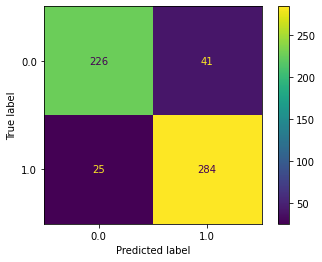

In [93]:
conf_matrix = confusion_matrix(y_true=expected, y_pred=y_pred_class2, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)

disp.plot()

plt.show()

In [94]:
expected.to_csv("expected_labels.csv", index=False)
y_pred_class1.to_csv("pred_labels_class1.csv", index=False)
y_pred_class2.to_csv("pred_labels_class2.csv", index=False)